In [1]:
import pandas as pd
import numpy as np
import itertools
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import spacy_sentence_bert
from sklearn.metrics import classification_report
import spacy_sentence_bert
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

<h4>Import data</h4>
First we will import the csv files with the data and we will convert them to pandas dataframes

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test_without_labels.csv")

Let's look what the first five lines the train and test dataframes contain

In [4]:
print(train_data.head())
print(test_data.head())

       Id                                              Title  \
0  227464  Netflix is coming to cable boxes, and Amazon i...   
1  244074  Pharrell, Iranian President React to Tehran 'H...   
2   60707                    Wildlife service seeks comments   
3   27883  Facebook teams up with Storyful to launch 'FB ...   
4  169596           Caesars plans US$880 mln New York casino   

                                             Content          Label  
0   if you subscribe to one of three rinky-dink (...  Entertainment  
1   pharrell, iranian president react to tehran '...  Entertainment  
2   the u.s. fish and wildlife service has reopen...     Technology  
3   the very nature of social media means it is o...     Technology  
4   caesars plans us$880 mln new york casino jul ...       Business  
       Id                                              Title  \
0  262120  Tracy Morgan upgraded to fair condition after ...   
1  175132  Smartphones Weigh on Samsung Electronics as Gu...   
2  

Let's see the number of data points, the number of features and the actual features of the train data

In [5]:
print("NUMBER OF DATA POINTS -",train_data.shape[0])
print("NUMBER OF FEATURES -",train_data.shape[1])
print("FEATURES -",train_data.columns.values)

NUMBER OF DATA POINTS - 111795
NUMBER OF FEATURES - 4
FEATURES - ['Id' 'Title' 'Content' 'Label']


Count how many examples belong to each label. We see that Entertainment label has the most examples, followed by Technology, Business and Health.

In [6]:
train_data['Label'].value_counts()

Entertainment    44834
Technology       30107
Business         24834
Health           12020
Name: Label, dtype: int64

Check if there are any nan values in our train dataframe. As we see there are none

In [7]:
#checking_null_values
train_data.isna().sum()

Id         0
Title      0
Content    0
Label      0
dtype: int64

Below we are plotting a bar plot which shows the distribution of examples per Label. Once again each clear that the Entertainment Label holds the most examples

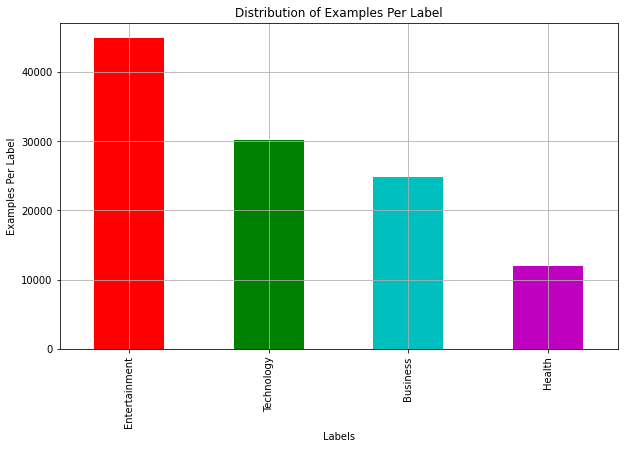

In [10]:
news_cat = train_data['Label'].value_counts()

plt.figure(figsize=(10,6))
my_colors = ['r','g','c','m']
news_cat.plot(kind='bar', color=my_colors)
plt.grid()
plt.xlabel("Labels")
plt.ylabel("Examples Per Label")
plt.title("Distribution of Examples Per Label")
plt.show()

<h4>Data Preprocessing</h4>
Now we will preprocess our data. Remove stopwords, remove special charachters, lemmatize and turn all words to lowercase

In [3]:
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
import nltk
import re

class Text_Preprocessin:
    def __init__(self, df):
        self.df = df

    def convert_text_lowercase(self):
        # Convert text to lowercase
        self.df['Content'] = self.df['Content'].str.lower()
        self.df['Title'] = self.df['Title'].str.lower()

    def remove_punctuation(self):
        # Remove punctuation: !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
        sep = '|' # separator
        punctuation_chars = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'
        mapping_table = str.maketrans(dict.fromkeys(punctuation_chars, ''))
        
        self.df['Content'] = sep.join(self.df['Content'].tolist()).translate(mapping_table).split(sep)
        self.df['Title'] = sep.join(self.df['Title'].tolist()).translate(mapping_table).split(sep)
      
    def remove_stopwords(self):
        # Remove stopwords
        stop = stopwords.words('english')
        self.df['Content'] = self.df['Content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
        self.df['Title'] = self.df['Title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    def remove_extra_spaces(self):
        self.df["Content"].str.replace('  ', ' ')
        self.df["Title"].str.replace('  ', ' ')


    def lemmatize(self):
        """
    Lemmatization
    Lemmatization is similar to stemming in reducing inflected words to their word stem 
    but differs in the way that it makes sure the root word (also called as lemma) 
    belongs to the language.
        """
        lemmatizer = WordNetLemmatizer()
        self.df['Content'] = self.df['Content'].apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()]))
        self.df['Title'] = self.df['Title'].apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()])) 

    def encode_labels(self):
        le = LabelEncoder()
        self.df['Label'] = le.fit_transform(self.df['Label'])

    def get_df(self):
        return self.df


We will experiment with the Content and Title feature to see which one gives us the best results (Accuracy, f1-score e.t.c) and we will predict the labels of our test set with the one that gives us the best results

Preprocess the content feature

In [4]:
# Preprocess the train data
df_train_text_preprocess = Text_Preprocessin(train_data)
df_train_text_preprocess.convert_text_lowercase()
df_train_text_preprocess.remove_punctuation()
df_train_text_preprocess.remove_stopwords()
df_train_text_preprocess.remove_extra_spaces()
#df_train_text_preprocess.lemmatize()
train_data = df_train_text_preprocess.get_df()
train_data.head()



,Id,Title,Content,Label
0,227464,netflix coming cable boxes amazon grocery over...,subscribe one three rinkydink comparatively sp...,Entertainment
1,244074,pharrell iranian president react tehran happy ...,pharrell iranian president react tehran happy ...,Entertainment
2,60707,wildlife service seeks comments,us fish wildlife service reopened comment peri...,Technology
3,27883,facebook teams storyful launch fb newswire,nature social media means often source real ti...,Technology
4,169596,caesars plans us880 mln new york casino,caesars plans us880 mln new york casino jul 01...,Business


Below we split our dataset to train and test sets to train our models. We do that for the Content and the Title feature

train_test_split for the Content feature

In [5]:
X_train_con, X_test_con, y_train_con, y_test_con = train_test_split(train_data['Content'], train_data['Label'], test_size=0.20, stratify=train_data['Label'], random_state=0)

train_test_split for the Title feature

In [22]:
X_train_ti, X_test_ti, y_train_ti, y_test_ti = train_test_split(train_data['Title'], train_data['Label'], test_size=0.20, stratify=train_data['Label'], random_state=0)

We will use the CountVectorizer library to turn our data to suitable form for our models to get trained with. Once again we will do that for the Content and the Title feature

Content feature

In [6]:
#building a TfidfVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer_con = TfidfVectorizer(min_df=3)
train_text_ohe_con = text_vectorizer_con.fit_transform(X_train_con)

#getting all the feature names (words)
train_text_features_con = text_vectorizer_con.get_feature_names()

#train_text_ohe.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts_con = train_text_ohe_con.sum(axis=0).A1

#zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict_con = dict(zip(list(train_text_features_con),train_text_fea_counts_con))

print("Total Number of Unique Words in Train Data :",len(train_text_features_con))

Total Number of Unique Words in Train Data : 122494


Title feature

In [23]:

text_vectorizer_ti = TfidfVectorizer(min_df=3)
train_text_ohe_ti = text_vectorizer_ti.fit_transform(X_train_ti)

#getting all the feature names (words)
train_text_features_ti = text_vectorizer_ti.get_feature_names()

#train_text_ohe.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts_ti = train_text_ohe_ti.sum(axis=0).A1

#zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict_ti = dict(zip(list(train_text_features_ti),train_text_fea_counts_ti))

print("Total Number of Unique Words in Train Data :",len(train_text_features_ti))

Total Number of Unique Words in Train Data : 14856


In [7]:
from sklearn.preprocessing import normalize #normalize every feature

train_text_ohe_con = normalize(train_text_ohe_con, axis=0)

#we use the same vectorizer that was trained on train data
cv_text_ohe_con = text_vectorizer_con.transform(X_test_con)

#don't forget to normalize every feature
cv_text_ohe_con = normalize(cv_text_ohe_con, axis=0)

In [24]:
train_text_ohe_ti = normalize(train_text_ohe_ti, axis=0)

#we use the same vectorizer that was trained on train data
cv_text_ohe_ti = text_vectorizer_ti.transform(X_test_ti)

#don't forget to normalize every feature
cv_text_ohe_ti = normalize(cv_text_ohe_ti, axis=0)

Below we have the plot_confusion_matrix function to later plot the confusion matrices

In [8]:
#this_function_plots_the_confusion_matrices_given_y_i_and_y_i_hat_
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(test_y, predict_y):

    C = confusion_matrix(test_y, predict_y) #confusion_mat
    A =(((C.T)/(C.sum(axis=1))).T) #recall_mat
    B =(C/C.sum(axis=0)) #precision_mat
    
    labels = [1,2,3,4]
    
    #representing_C_in_heatmap_format
    print("-"*40, "Confusion Matrix", "-"*40)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    #representing_B_in_heatmap_format
    print("-"*40, "Precision Matrix (Columm Sum=1)", "-"*40)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    #representing_A_in_heatmap_format
    print("-"*40, "Recall Matrix (Row Sum=1)", "-"*40)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

<h3>Multinomial Naive Bayes</h3>
First we will experiment with the Multinomial Naive Bayes and we will also choose the feature that gives us the best results

Content feature

For Model 0
Log Loss : 0.2729365589071955
For Model 1
Log Loss : 0.25926101501462634
For Model 2
Log Loss : 0.2420639050334084
For Model 3
Log Loss : 0.209221429965198
For Model 4
Log Loss : 0.21180000120063247
For Model 5
Log Loss : 0.2769895684463617
For Model 6
Log Loss : 0.36237205548151813
For Model 7
Log Loss : 0.38482590826517316


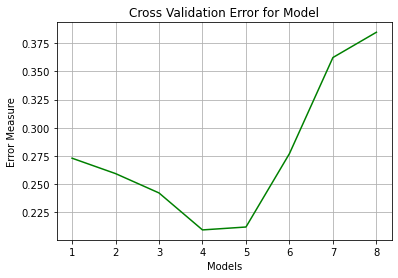

Best model is  MultinomialNB(alpha=0.1) The train log loss is: 0.11104523566339072
Best model is  MultinomialNB(alpha=0.1) The cross validation log loss is: 0.209221429965198


In [19]:



models_ls = [MultinomialNB(alpha=0.00001), MultinomialNB(alpha=0.0001), MultinomialNB(alpha=0.001),
MultinomialNB(alpha=0.1), MultinomialNB(alpha=1), MultinomialNB(alpha=10), 
MultinomialNB(alpha=100), MultinomialNB(alpha=1000)]

cv_log_error_array = []

for i, mod in enumerate(models_ls):
    print(f"For Model {i}")
    clf = mod
    clf.fit(train_text_ohe_con, y_train_con)
    
    nb_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    nb_sig_clf.fit(train_text_ohe_con, y_train_con)
    
    sig_clf_probs = nb_sig_clf.predict_proba(cv_text_ohe_con)
    
    cv_log_error_array.append(log_loss(y_test_con, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    #to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_test_con, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(list(range(1,9)), cv_log_error_array,c='g')

    
plt.grid()
plt.xticks(list(range(1,9)))
plt.title("Cross Validation Error for Model")
plt.xlabel("Models")
plt.ylabel("Error Measure")
plt.show()

best_model = np.argmin(cv_log_error_array)

# Here we choose the best model
clf = models_ls[best_model]
clf.fit(train_text_ohe_con, y_train_con)

nb_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
nb_sig_clf.fit(train_text_ohe_con, y_train_con)

predict_y = nb_sig_clf.predict_proba(train_text_ohe_con)
print("Best model is ", str(models_ls[best_model]), "The train log loss is:",log_loss(y_train_con, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = nb_sig_clf.predict_proba(cv_text_ohe_con)
print("Best model is ", models_ls[best_model], "The cross validation log loss is:",log_loss(y_test_con, predict_y, labels=clf.classes_, eps=1e-15))

In [90]:
from sklearn.metrics import accuracy_score
predicted_y = nb_sig_clf.predict(cv_text_ohe_con)
train_accuracy = (nb_sig_clf.score(train_text_ohe_con, y_train_con)*100)
cv_accuracy = (accuracy_score(predicted_y, y_test_con)*100)

print("Naive Bayes Train Accuracy with Content feature -",train_accuracy)
print("Naive Bayes CV Accuracy with Content feature -",cv_accuracy)

Naive Bayes Train Accuracy with Content feature - 96.5819133234939
Naive Bayes CV Accuracy with Content feature - 94.04713985419741


---------------------------------------- Confusion Matrix ----------------------------------------


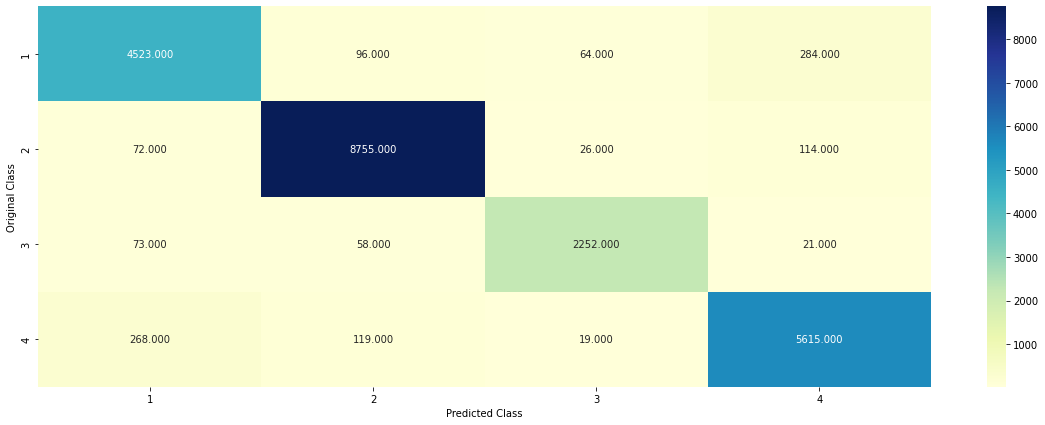

---------------------------------------- Precision Matrix (Columm Sum=1) ----------------------------------------


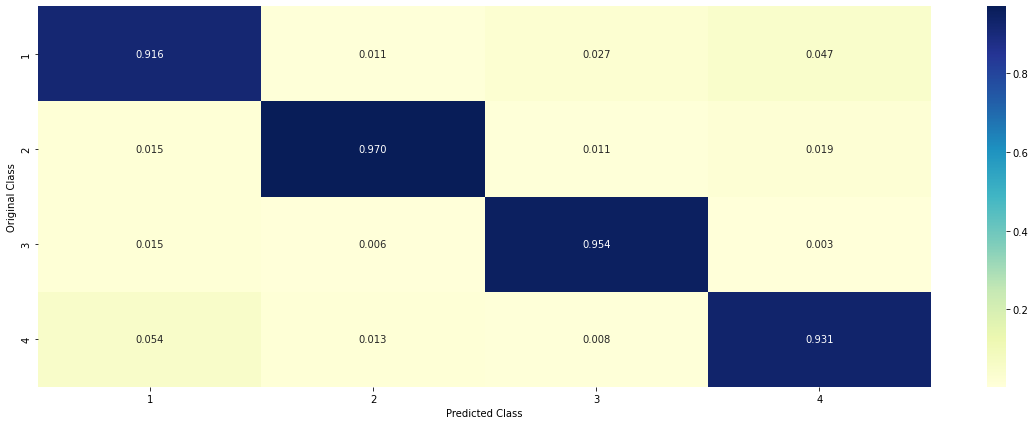

---------------------------------------- Recall Matrix (Row Sum=1) ----------------------------------------


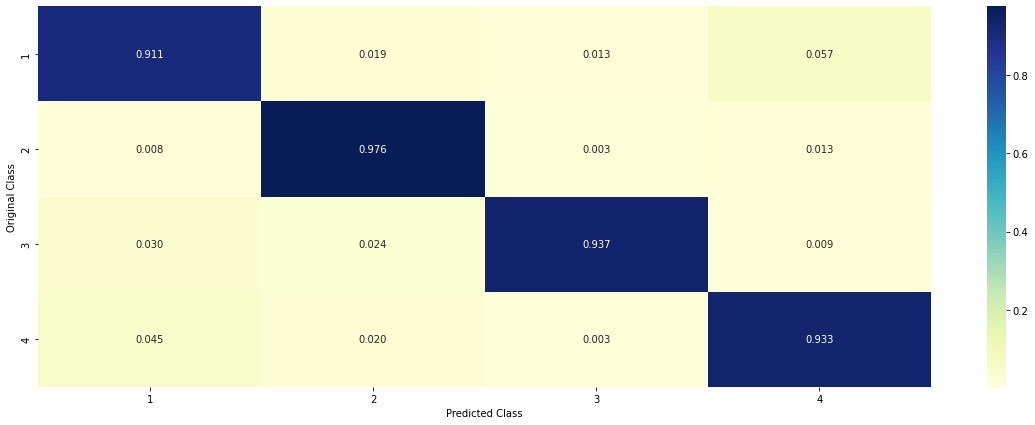

In [20]:
plot_confusion_matrix(y_test_con, nb_sig_clf.predict(cv_text_ohe_con.toarray()))

In [91]:
from sklearn.metrics import classification_report
print(classification_report(predicted_y, y_test_con, target_names=train_data['Label'].unique()))

               precision    recall  f1-score   support

Entertainment       0.90      0.91      0.91      4889
   Technology       0.98      0.96      0.97      9109
     Business       0.93      0.95      0.94      2350
       Health       0.92      0.93      0.93      6011

     accuracy                           0.94     22359
    macro avg       0.93      0.94      0.94     22359
 weighted avg       0.94      0.94      0.94     22359



We perform the same operations for the Title feature

For Model 0
Log Loss : 0.3686776197169032
For Model 1
Log Loss : 0.36105750813998033
For Model 2
Log Loss : 0.3484884212007887
For Model 3
Log Loss : 0.2994036011881409
For Model 4
Log Loss : 0.2788877278032599
For Model 5
Log Loss : 0.2847979170589214
For Model 6
Log Loss : 0.28976851602292286
For Model 7
Log Loss : 0.2905757659496702


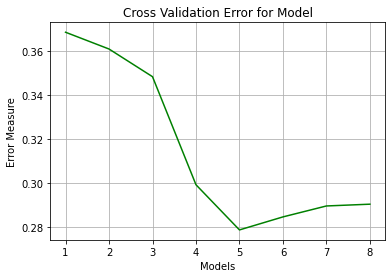

Best model is  MultinomialNB(alpha=1) The train log loss is: 0.2069049226508249
Best model is  MultinomialNB(alpha=1) The cross validation log loss is: 0.2788877278032599


In [ ]:
cv_log_error_array = []

for i, mod in enumerate(models_ls):
    print(f"For Model {i}")
    clf = mod
    clf.fit(train_text_ohe_ti, y_train_ti)
    
    nb_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    nb_sig_clf.fit(train_text_ohe_ti, y_train_ti)
    
    sig_clf_probs = nb_sig_clf.predict_proba(cv_text_ohe_ti)
    
    cv_log_error_array.append(log_loss(y_test_ti, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    #to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_test_ti, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(list(range(1,5)), cv_log_error_array,c='g')

    
plt.grid()
plt.xticks(list(range(1,5)))
plt.title("Cross Validation Error for Model")
plt.xlabel("Models")
plt.ylabel("Error Measure")
plt.show()

best_model = np.argmin(cv_log_error_array)

# Here we choose the best model
clf = models_ls[best_model]
clf.fit(train_text_ohe_ti, y_train_ti)

nb_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
nb_sig_clf.fit(train_text_ohe_ti, y_train_ti)

predict_y = nb_sig_clf.predict_proba(train_text_ohe_ti)
print("Best model is ", str(models_ls[best_model]), "The train log loss is:",log_loss(y_train_ti, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = nb_sig_clf.predict_proba(cv_text_ohe_ti)
print("Best model is ", models_ls[best_model], "The cross validation log loss is:",log_loss(y_test_ti, predict_y, labels=clf.classes_, eps=1e-15))

In [93]:
predicted_y = nb_sig_clf.predict(cv_text_ohe_ti)
train_accuracy = (nb_sig_clf.score(train_text_ohe_ti, y_train_ti)*100)
cv_accuracy = (accuracy_score(predicted_y, y_test_ti)*100)

print("Naive Bayes Train Accuracy with Title feature -",train_accuracy)
print("Naive Bayes CV Accuracy with Title feature -",cv_accuracy)

Naive Bayes Train Accuracy with Title feature - 93.72847622881166
Naive Bayes CV Accuracy with Title feature - 91.23395500693233


---------------------------------------- Confusion Matrix ----------------------------------------


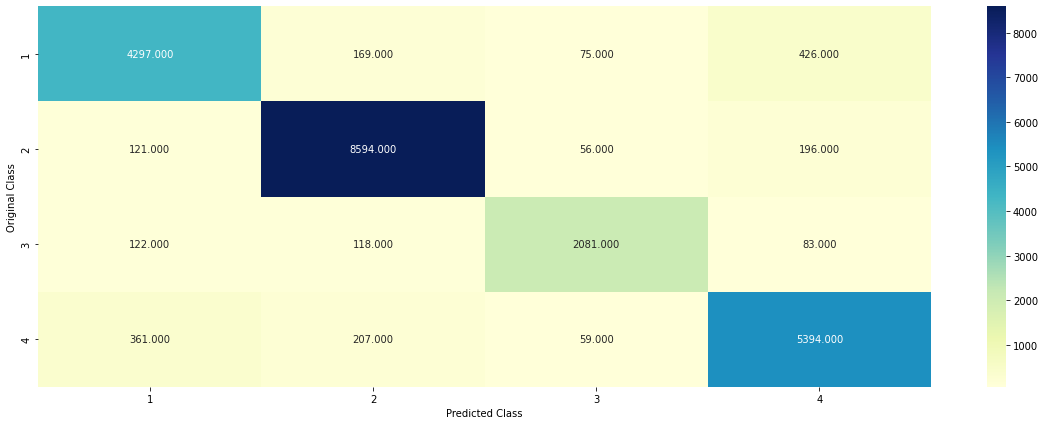

---------------------------------------- Precision Matrix (Columm Sum=1) ----------------------------------------


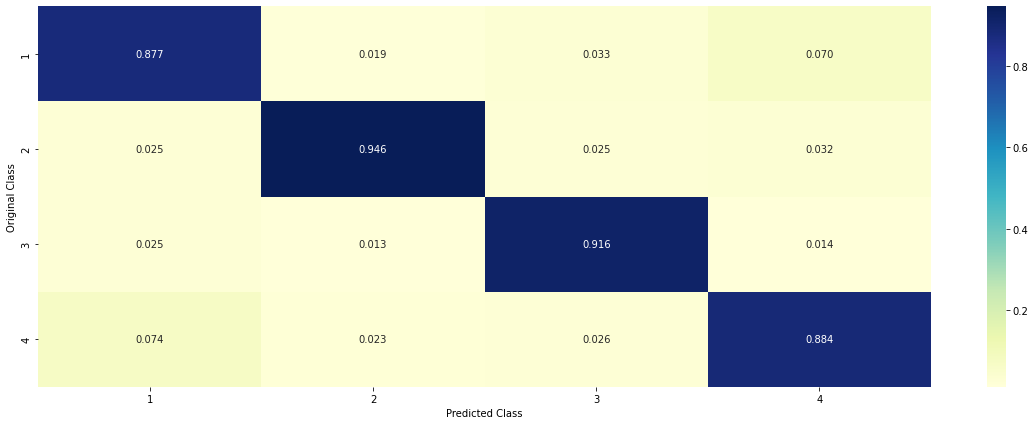

---------------------------------------- Recall Matrix (Row Sum=1) ----------------------------------------


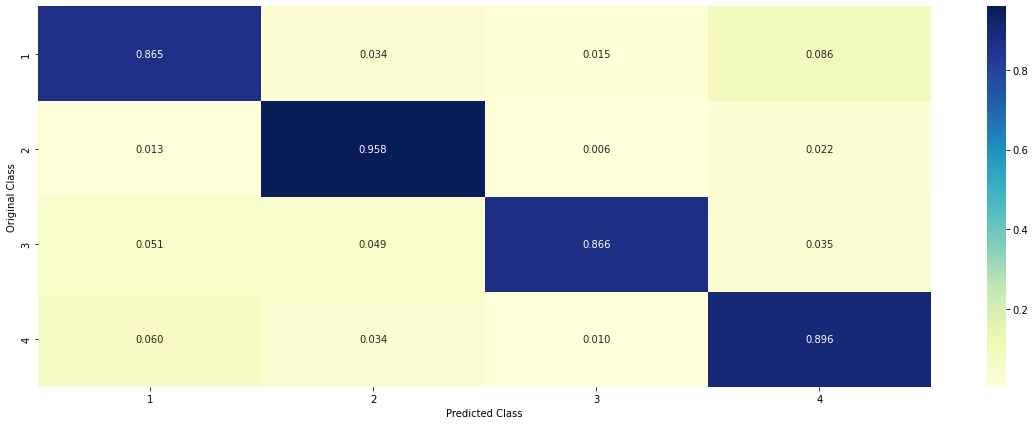

In [26]:
plot_confusion_matrix(y_test_ti, nb_sig_clf.predict(cv_text_ohe_ti.toarray()))

<h3>SGD classifier</h3>

For Model 0
Log Loss : 0.15958870332014904
For Model 1
Log Loss : 0.17923106281779017
For Model 2
Log Loss : 0.3508264239585726
For Model 3
Log Loss : 0.45546228937751276
For Model 4
Log Loss : 0.13273673041493467
For Model 5
Log Loss : 0.14976189412253443


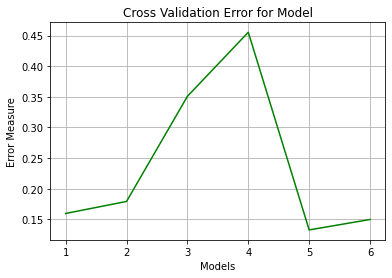

Best model is  SGDClassifier(loss='modified_huber') The train log loss is: 0.060094431071868376
Best model is  SGDClassifier(loss='modified_huber') The cross validation log loss is: 0.1325684570599174


In [10]:


models_ls = [SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001),
SGDClassifier(loss='hinge', penalty='l2', alpha=0.0002),
SGDClassifier(loss='hinge', penalty='l1', alpha=0.0001),
SGDClassifier(loss='hinge', penalty='l1', alpha=0.0002),
SGDClassifier(loss='modified_huber', penalty='l2', alpha=0.0001),
SGDClassifier(loss='modified_huber', penalty='l2', alpha=0.0002),
]

cv_log_error_array = []

for i, mod in enumerate(models_ls):
    print(f"For Model {i}")
    clf = mod
    clf.fit(train_text_ohe_con, y_train_con)
    
    sgd_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sgd_sig_clf.fit(train_text_ohe_con, y_train_con)
    
    sig_clf_probs = sgd_sig_clf.predict_proba(cv_text_ohe_con)
    
    cv_log_error_array.append(log_loss(y_test_con, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    #to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_test_con, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(list(range(1,7)), cv_log_error_array,c='g')

    
plt.grid()
plt.xticks(list(range(1,7)))
plt.title("Cross Validation Error for Model")
plt.xlabel("Models")
plt.ylabel("Error Measure")
plt.show()

best_model = np.argmin(cv_log_error_array)

# Here we choose the best model
clf = models_ls[best_model]
clf.fit(train_text_ohe_con, y_train_con)

sgd_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sgd_sig_clf.fit(train_text_ohe_con, y_train_con)

predict_y = sgd_sig_clf.predict_proba(train_text_ohe_con)
print("Best model is ", str(models_ls[best_model]), "The train log loss is:",log_loss(y_train_con, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sgd_sig_clf.predict_proba(cv_text_ohe_con)
print("Best model is ", models_ls[best_model], "The cross validation log loss is:",log_loss(y_test_con, predict_y, labels=clf.classes_, eps=1e-15))

In [11]:
predicted_y = sgd_sig_clf.predict(cv_text_ohe_con)
train_accuracy = (sgd_sig_clf.score(train_text_ohe_con, y_train_con)*100)
cv_accuracy = (accuracy_score(predicted_y, y_test_con)*100)

print("SGD Train Accuracy with Content feature -",train_accuracy)
print("SGD CV Accuracy with Content feature -",cv_accuracy)

SGD Train Accuracy with Content feature - 98.425689878796
SGD CV Accuracy with Content feature - 96.24312357439958


In [12]:
print(classification_report(predicted_y, y_test_con, target_names=train_data['Label'].unique()))

               precision    recall  f1-score   support

Entertainment       0.94      0.94      0.94      4965
   Technology       0.98      0.98      0.98      8942
     Business       0.97      0.96      0.97      2412
       Health       0.95      0.95      0.95      6040

     accuracy                           0.96     22359
    macro avg       0.96      0.96      0.96     22359
 weighted avg       0.96      0.96      0.96     22359



---------------------------------------- Confusion Matrix ----------------------------------------


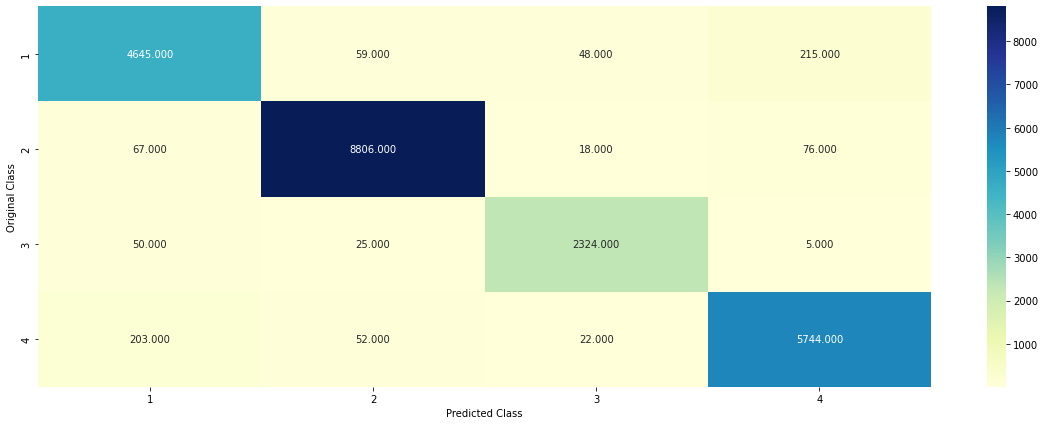

---------------------------------------- Precision Matrix (Columm Sum=1) ----------------------------------------


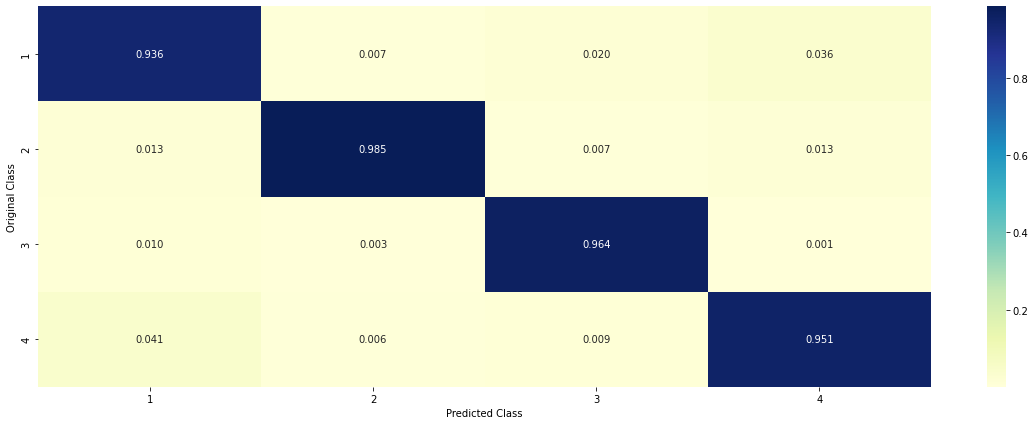

---------------------------------------- Recall Matrix (Row Sum=1) ----------------------------------------


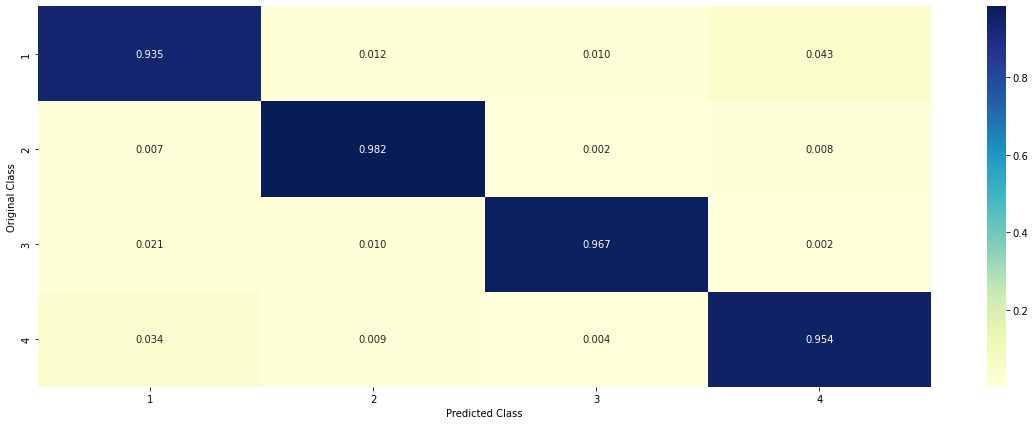

In [18]:
plot_confusion_matrix(y_test_con, sgd_sig_clf.predict(cv_text_ohe_con.toarray()))

<h4>Random Forest Classifier</h4>

For Model 0
Log Loss : 0.2048191684782695
For Model 1
Log Loss : 0.2159787805906366
For Model 2
Log Loss : 0.20202999973093283
For Model 3
Log Loss : 0.21216590204733446


ValueError: x and y must have same first dimension, but have shapes (8,) and (4,)

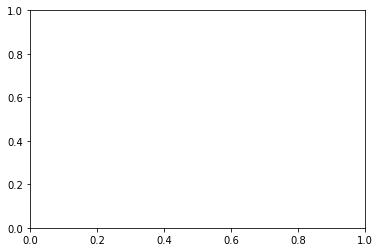

In [9]:
models_ls = [RandomForestClassifier(n_estimators=100, criterion='gini'),
RandomForestClassifier(n_estimators=100, criterion='entropy'),
RandomForestClassifier(n_estimators=150, criterion='gini'),
RandomForestClassifier(n_estimators=150, criterion='entropy')
]

cv_log_error_array = []

for i, mod in enumerate(models_ls):
    print(f"For Model {i}")
    clf = mod
    clf.fit(train_text_ohe_con, y_train_con)
    
    rfc_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    rfc_sig_clf.fit(train_text_ohe_con, y_train_con)
    
    sig_clf_probs = rfc_sig_clf.predict_proba(cv_text_ohe_con)
    
    cv_log_error_array.append(log_loss(y_test_con, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    #to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_test_con, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(list(range(1,5)), cv_log_error_array,c='g')

    
plt.grid()
plt.xticks(list(range(1,5)))
plt.title("Cross Validation Error for Model")
plt.xlabel("Models")
plt.ylabel("Error Measure")
plt.show()



In [13]:
best_model = np.argmin(cv_log_error_array)

# Here we choose the best model
clf = models_ls[best_model]
clf.fit(train_text_ohe_con, y_train_con)

rfc_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
rfc_sig_clf.fit(train_text_ohe_con, y_train_con)

predict_y = rfc_sig_clf.predict_proba(train_text_ohe_con)
print("Best model is ", str(models_ls[best_model]), "The train log loss is:",log_loss(y_train_con, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = rfc_sig_clf.predict_proba(cv_text_ohe_con)
print("Best model is ", models_ls[best_model], "The cross validation log loss is:",log_loss(y_test_con, predict_y, labels=clf.classes_, eps=1e-15))

Best model is  RandomForestClassifier(n_estimators=150) The train log loss is: 0.040375219497970204
Best model is  RandomForestClassifier(n_estimators=150) The cross validation log loss is: 0.20230759144320742


In [15]:
predicted_y = rfc_sig_clf.predict(cv_text_ohe_con)
train_accuracy = (rfc_sig_clf.score(train_text_ohe_con, y_train_con)*100)
cv_accuracy = (accuracy_score(predicted_y, y_test_con)*100)

print("RFC Train Accuracy with Content feature -",train_accuracy)
print("RFC CV Accuracy with Content feature -",cv_accuracy)

RFC Train Accuracy with Content feature - 99.83451853839617
RFC CV Accuracy with Content feature - 93.58200277293261


In [16]:

plot_confusion_matrix(y_test_con, rfc_sig_clf.predict(cv_text_ohe_con.toarray()))

MemoryError: Unable to allocate 20.4 GiB for an array with shape (22359, 122494) and data type float64

In [17]:
print(classification_report(predicted_y, y_test_con, target_names=train_data['Label'].unique()))

               precision    recall  f1-score   support

Entertainment       0.89      0.91      0.90      4876
   Technology       0.97      0.96      0.97      9053
     Business       0.93      0.94      0.93      2378
       Health       0.92      0.92      0.92      6052

     accuracy                           0.94     22359
    macro avg       0.93      0.93      0.93     22359
 weighted avg       0.94      0.94      0.94     22359



<h4>Predictions with the Test Set</h4>

In [35]:
test_data.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [36]:
#checking null values
test_data.isna().sum()

ArticleId    0
Text         0
dtype: int64

<h4>Preprocess the Test Data</h4>

In [13]:
# Preprocess the train data
df_test_text_preprocess = Text_Preprocessin(test_data)
df_test_text_preprocess.convert_text_lowercase()
df_test_text_preprocess.remove_punctuation()
df_test_text_preprocess.remove_stopwords()
df_test_text_preprocess.remove_extra_spaces()
df_test_text_preprocess.lemmatize()
test_data = df_test_text_preprocess.get_df()
test_data.head()

,Id,Title,Content
0,262120,tracy morgan upgraded fair condition crash,actor comedian tracy morgan upgraded fair cond...
1,175132,smartphones weigh samsung electronics guidance...,samsung electronics co ltd tuesday issued unex...
2,218739,fbi denies fumbling testimony xmen director br...,michael f egan iii said press conference thurs...
3,253483,bachelorette 2014 spoiler week 3 recap eric hi...,mixed emotion happen tonight onthe bachelorett...
4,224109,barack obama honour frankie knuckle letter lov...,u president barack obama paid special tribute ...


In [14]:


#we use the same vectorizer that was trained on train data
test_text_ohe = text_vectorizer_con.transform(test_data['Content'])

#don't forget to normalize every feature
test_text_ohe = normalize(test_text_ohe, axis=0)

Use the same CalibratedClassifierCV which is used in SGD Model to predict the target (Category) of Test Set.

In [15]:
#lr_sig_clf is the same CalibratedClassifierCV which is used in Logistic Regression Model
#test_final_ohe_nb = nb_sig_clf.predict(test_text_ohe)
test_final_ohe_sgd = sgd_sig_clf.predict(test_text_ohe)
#test_final_ohe_rfc = rfc_sig_clf.predict(test_text_ohe)

#test_final_list_nb = test_final_ohe_nb.tolist()
test_final_list = test_final_ohe_sgd.tolist()
#test_final_list_rfc = test_final_ohe_rfc.tolist()
 

In [16]:
test_data = test_data.drop("Content", axis=1)
test_data = test_data.drop("Title", axis=1)

# nb_preds = test_data
# nb_preds['Label'] = test_final_list_nb

sgd_preds = test_data
sgd_preds['Label'] = test_final_list

#rfc_preds = test_data
#rfc_preds['Label'] = test_final_list_rfc

In [17]:
#nb_preds.to_csv('KonstantinosMalonas_NB.csv')
#sgd_preds = sgd_preds.reset_index(drop=True)
sgd_preds.to_csv('KonstantinosMalonas_SGD.csv',index=False)
#rfc_preds = rfc_preds.reset_index(drop=True)
#rfc_preds.to_csv('KonstantinosMalonas_RFC.csv',index=False)

Since the SGD model gave us the best results we combine it with **spacy_sentence_bert** model to get better to get better results.

In [27]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv("test_without_labels.csv")

nlp = spacy_sentence_bert.load_model('en_stsb_distilbert_base')
train_data['vector_content'] = train_data['Content'].apply(lambda x: nlp(x).vector)
test_data['vector_content'] = test_data['Content'].apply(lambda x: nlp(x).vector)
sgd_sig_clf.fit(train_data['vector_content'].tolist(), train_data['Label'].tolist())



NameError: name 'rfc_sig_clf' is not defined

In [28]:
predictions = sgd_sig_clf.predict(test_data['vector_content'].tolist())
results = {'Id':test_data['Id'].values, 'Predicted':list(predictions)}
df = pd.DataFrame.from_dict(results)

df.to_csv("Malonas.csv", index=False)